In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2,VGG19
from sklearn.utils import resample
from PIL import UnidentifiedImageError  # Import UnidentifiedImageError
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model  # Add this import statement
from tensorflow.keras import layers


In [2]:
# Load data with error handling for invalid image files
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            try:
                # Only load if it's a valid image file
                image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
                image_array = img_to_array(image)
                images.append(image_array)
                labels.append(label)
            except UnidentifiedImageError:
                print(f"UnidentifiedImageError: Could not load {image_path}, skipping.")
            except Exception as e:
                print(f"Error: {e} while loading {image_path}, skipping.")
    return np.array(images), np.array(labels)

folder_path = "datasets/Oral cancer Dataset 2.0"
images, labels = load_data(folder_path)

C:\Users\latia\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\101.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\200.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\273.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\317.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\328.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\407.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\450.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\455.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\481.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\485.jpeg, skipping.


In [3]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

In [6]:
# Define and compile the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [7]:
# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Add your own classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
predictions = layers.Dense(1, activation='sigmoid')(x)

In [9]:
model_VGG19 = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model_VGG19.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,550,721 (78.39 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model_VGG19, to_file='./architecture/vgg19_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [12]:
model_VGG19.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [14]:
checkpoint_filepath = './models/best_model_resnet4.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [15]:
# Train the model
history = model_VGG19.fit(
    x= X_train,
    y= y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6664 - loss: 3.0520 - precision: 0.6654 - recall: 0.6718
Epoch 1: val_accuracy improved from -inf to 0.85106, saving model to ./models/best_model_resnet4.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.6694 - loss: 3.0101 - precision: 0.6679 - recall: 0.6746 - val_accuracy: 0.8511 - val_loss: 0.6882 - val_precision: 0.8372 - val_recall: 0.8372 - learning_rate: 0.0010
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8817 - loss: 0.5738 - precision: 0.8938 - recall: 0.8554
Epoch 2: val_accuracy improved from 0.85106 to 0.86170, saving model to ./models/best_model_resnet4.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.8815 - loss: 0.5718 - precision: 0.8931 - recall: 0.8558 - val_accuracy: 0.8617 - val_loss: 0.4333 - val_precision: 0.8061 - val_recall: 0.9186 - learning_rate: 0.0010
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8901 - loss: 0.3644 - precision: 0.8913 - reca

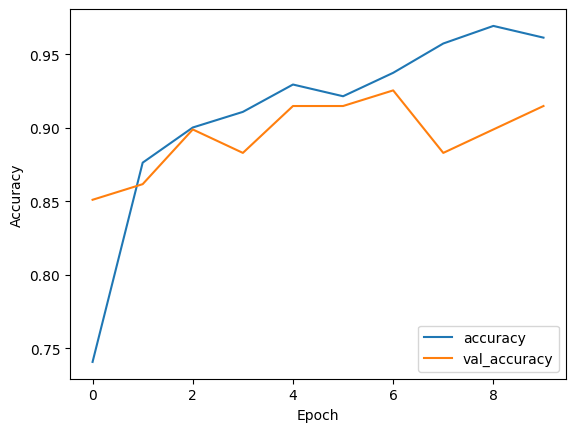

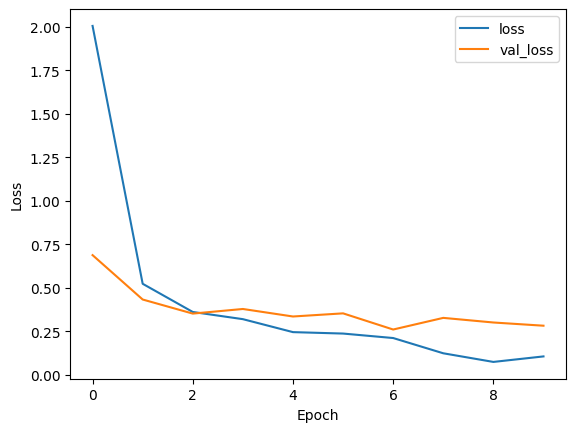

In [16]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [17]:
# Evaluate the model on the test set
evaluation = model_VGG19.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")
print(f"Test Precision: {evaluation[2]}")
print(f"Test Recall: {evaluation[3]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9185 - loss: 0.2801 - precision: 0.9084 - recall: 0.9115
Test Loss: 0.26086047291755676
Test Accuracy: 0.9255319237709045
Test Precision: 0.9285714030265808
Test Recall: 0.9069767594337463


In [18]:
# Make predictions on the test set
y_pred = (model_VGG19.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['Non Cancer', 'Cancer'])
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step
              precision    recall  f1-score   support

  Non Cancer       0.92      0.94      0.93       102
      Cancer       0.93      0.91      0.92        86

    accuracy                           0.93       188
   macro avg       0.93      0.92      0.92       188
weighted avg       0.93      0.93      0.93       188



In [19]:
y_pred

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
    

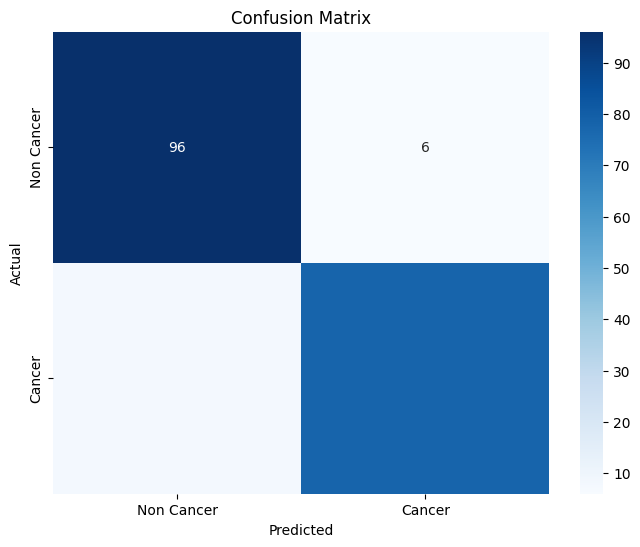

In [20]:
import seaborn as sns

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Cancer', 'Cancer'], yticklabels=['Non Cancer', 'Cancer'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

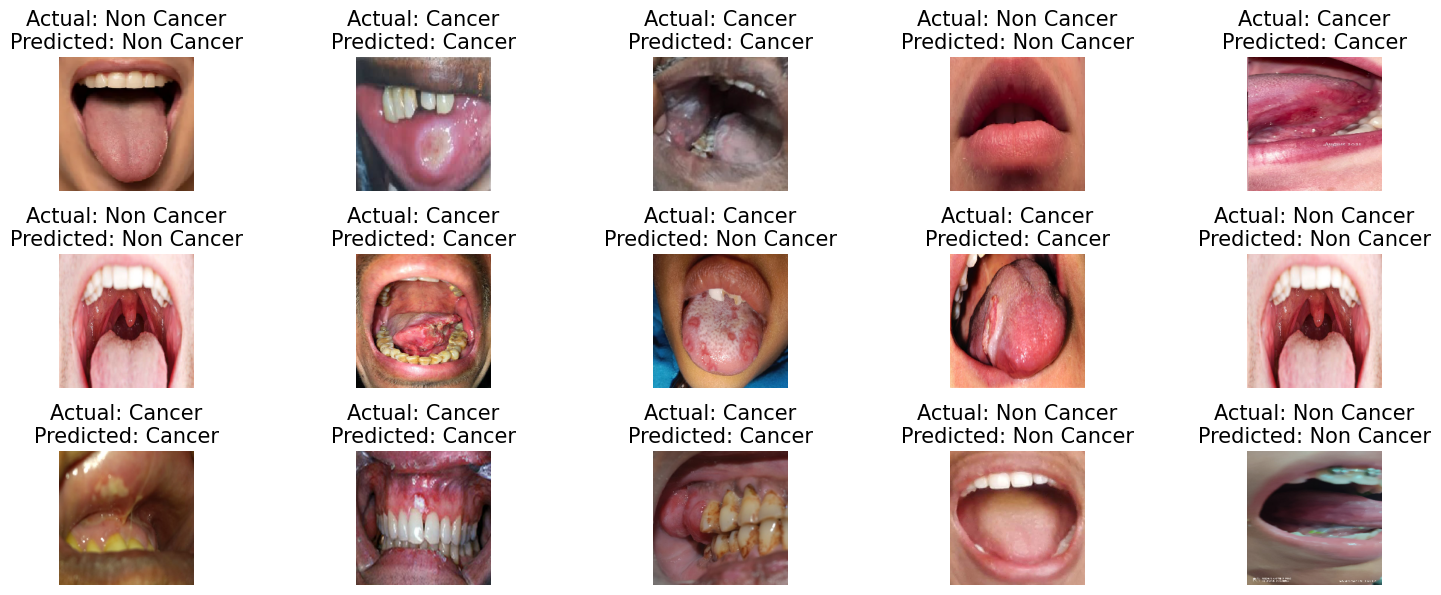

In [21]:
import matplotlib.pyplot as plt

def display_images_with_predictions(X_test, y_test, y_pred, num_images=10):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)  # Adjust the layout as needed
        plt.imshow(X_test[i].astype('uint8'))  # Convert to uint8 for correct display
        plt.axis('off')
        
        # Display actual and predicted labels
        actual = 'Cancer' if y_test[i] == 0 else 'Non Cancer'
        predicted = 'Cancer' if y_pred[i][0] == 0 else 'Non Cancer'
        plt.title(f'Actual: {actual}\nPredicted: {predicted}', fontsize=15)

    plt.tight_layout()
    plt.show()

# Call the function to display images
display_images_with_predictions(X_test, y_test, y_pred, num_images=15)  # Display 15 images


In [22]:
def evaluate_model(model, new_data_path):
    new_images, new_labels = load_data(new_data_path)
    predictions = model.predict(new_images)
    predicted_classes = (predictions > 0.5).astype(int)

    # Evaluate the model
    accuracy = np.mean(predicted_classes.flatten() == new_labels.flatten())
    print(f"Accuracy on new data: {accuracy * 100:.2f}%")

# Call the evaluation function with the path to new data
evaluate_model(model_VGG19, "test")


C:\Users\latia\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step
Accuracy on new data: 96.40%


16/16 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step


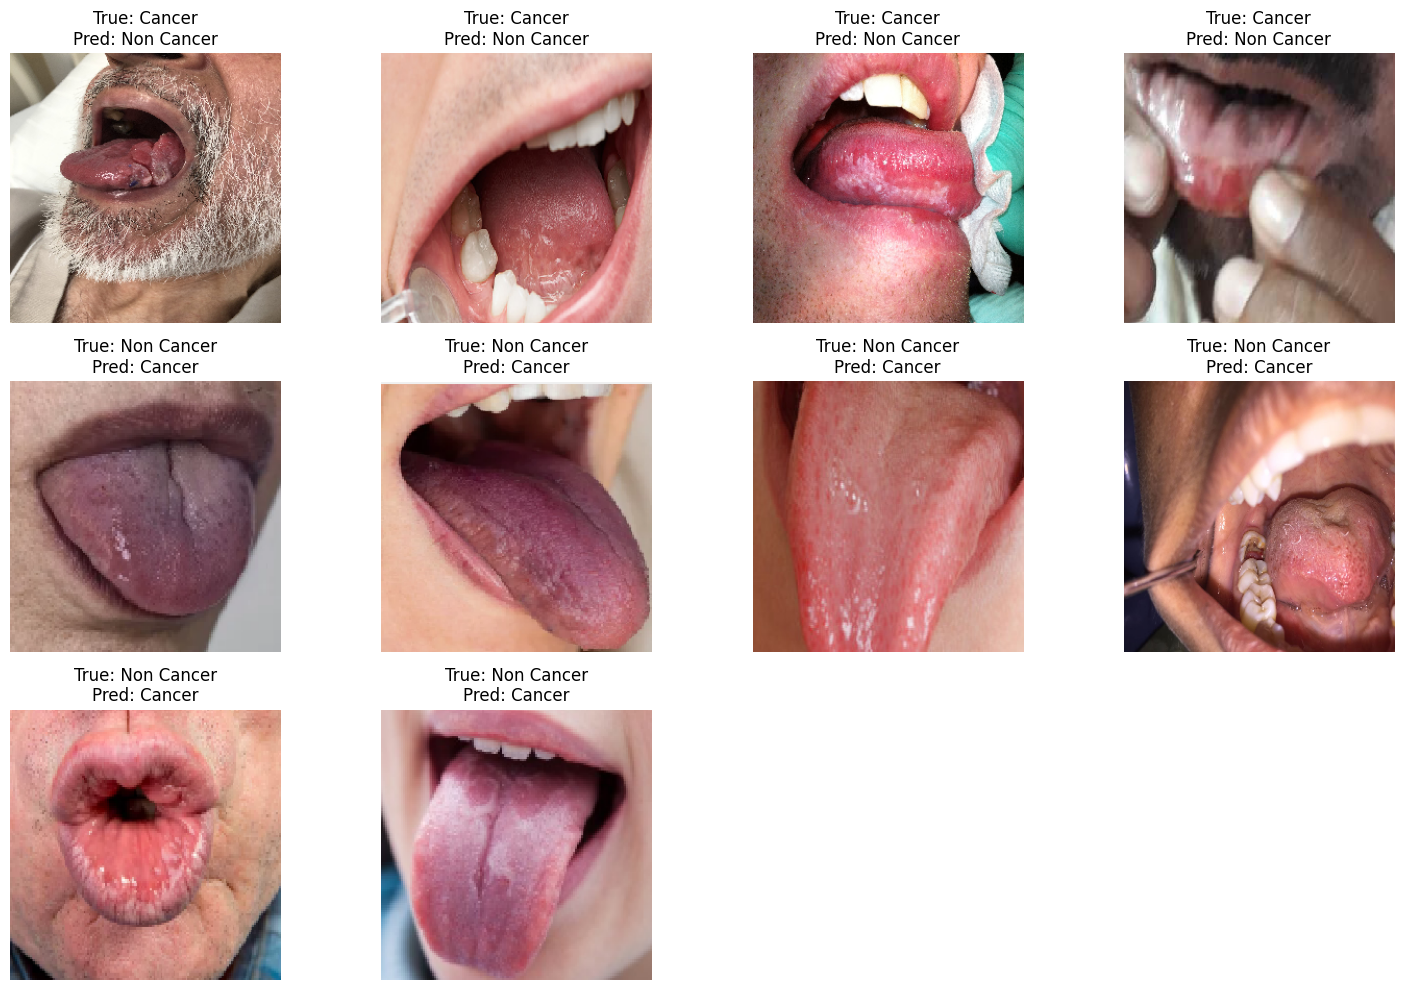

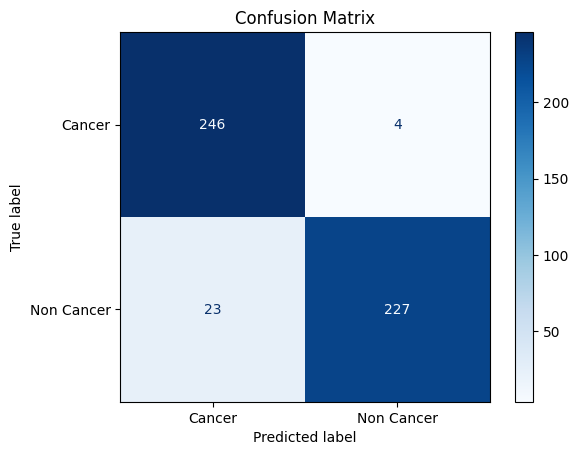

Classification Report:
               precision    recall  f1-score   support

      Cancer       0.91      0.98      0.95       250
  Non Cancer       0.98      0.91      0.94       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



FileNotFoundError: [Errno 2] No such file or directory: 'D:/DL Project/misclassified_images/image_0.png'

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load images from a directory
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to analyze misclassifications and generate classification report
def analyze_misclassifications(model, data_path):
    new_images, new_labels = load_data(data_path)
    predictions = model.predict(new_images)
    predicted_classes = (predictions > 0.5).astype(int)

    # Identify misclassified images
    misclassified_indices = np.where(predicted_classes.flatten() != new_labels.flatten())[0]

    # Display misclassified images
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(misclassified_indices[:10]):  # Display first 10 misclassified images
        plt.subplot(3, 4, i + 1)
        plt.imshow(new_images[idx].astype('uint8'))
        plt.axis('off')
        plt.title(f'True: {"Cancer" if new_labels[idx] == 0 else "Non Cancer"}\nPred: {"Cancer" if predicted_classes[idx][0] == 0 else "Non Cancer"}')

    plt.tight_layout()
    plt.show()

    # Generate and display confusion matrix
    cm = confusion_matrix(new_labels, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancer", "Non Cancer"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(new_labels, predicted_classes, target_names=["Cancer", "Non Cancer"])
    print("Classification Report:\n", report)

    # Optionally, save misclassified images for retraining
    misclassified_images = new_images[misclassified_indices]
    misclassified_labels = new_labels[misclassified_indices]
    for i, idx in enumerate(misclassified_indices):
        # Save misclassified images to a specific directory for further analysis
        save_path = f"D:/DL Project/misclassified_images/image_{i}.png"
        plt.imsave(save_path, new_images[idx].astype('uint8'))
        print(f"Saved misclassified image: {save_path}")

# Call the function to analyze misclassifications
analyze_misclassifications(model_VGG19, "test")


In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load images from a directory
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to evaluate the model on unseen images
def evaluate_model(model, test_data_path):
    # Load new unseen data
    X_test, y_test = load_data(test_data_path)
    
    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = (predictions > 0.5).astype(int)

    # Calculate metrics
    accuracy = np.mean(predicted_classes.flatten() == y_test.flatten())
    print(f'Accuracy: {accuracy:.4f}')

    # Generate confusion matrix and classification report
    cm = confusion_matrix(y_test, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancer", "Non Cancer"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Unseen Data')
    plt.show()

    report = classification_report(y_test, predicted_classes, target_names=["Cancer", "Non Cancer"])
    print("Classification Report:\n", report)

    # Visualize some predictions
    num_images = 10  # Adjust the number of images to display
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, 4, i + 1)
        plt.imshow(X_test[i].astype('uint8'))
        plt.axis('off')
        actual = 'Cancer' if y_test[i] == 0 else 'Non Cancer'
        predicted = 'Cancer' if predicted_classes[i][0] == 0 else 'Non Cancer'
        plt.title(f'Actual: {actual}\nPred: {predicted}')

    plt.tight_layout()
    plt.show()

# Call the function to evaluate the model on unseen images
evaluate_model(model_VGG19, "test")  # Specify the path to the unseen test data


C:\Users\latia\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 3/16 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


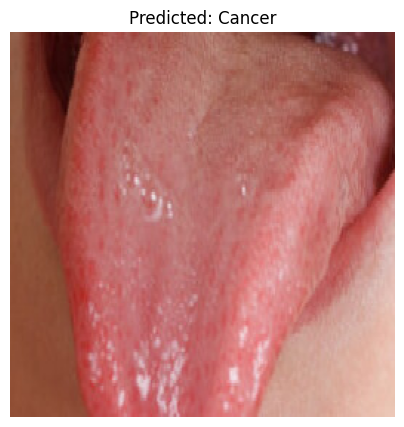

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load a single image
def load_single_image(image_path):
    image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

# Function to evaluate the model on a single image
def evaluate_single_image(model, image_path, true_label=None):
    # Load the image
    image = load_single_image(image_path)
    
    # Make predictions
    prediction = model.predict(image)
    predicted_class = 0 if prediction < 0.5 else 1  # 0 for Cancer, 1 for Non Cancer
    
    # Map predictions to labels
    predicted_label = 'Cancer' if predicted_class == 0 else 'Non Cancer'
    
    # Display the image with the prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image[0].astype('uint8'))  # Remove batch dimension for visualization
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}', fontsize=12)
    plt.show()

# Example usage with the model
# Provide the correct image path and true label (0 for Cancer, 1 for Non Cancer) if available
evaluate_single_image(model_VGG19, "test/NON CANCER/012.jpeg", true_label=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


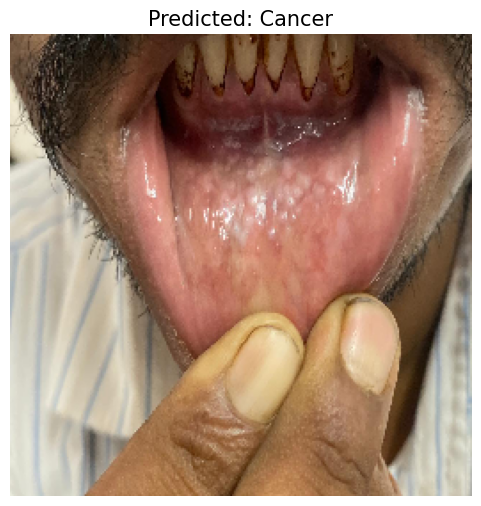

Predicted label for the image: Cancer


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess a single image
def load_single_image(image_path):
    image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
    image_array = img_to_array(image)
    return np.expand_dims(image_array, axis=0)  # Expand dimensions to match model input shape

# Function to evaluate the model on a single image
def evaluate_single_image(model, image_path):
    # Load the single image
    X_single = load_single_image(image_path)
    
    # Make prediction
    prediction = model.predict(X_single)
    predicted_class = (prediction > 0.5).astype(int)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(X_single[0].astype('uint8'))
    plt.axis('off')
    
    # Display the prediction
    predicted_label = "Cancer" if predicted_class[0][0] == 0 else "Non Cancer"
    plt.title(f'Predicted: {predicted_label}', fontsize=15)
    plt.show()

    # Return the predicted label for further use if needed
    return predicted_label

# Specify the path to the single image
image_path = "test/CANCER/078.jpeg"  # Update the path to your image

# Call the function to evaluate the single image
predicted_label = evaluate_single_image(model_VGG19, image_path)
print(f'Predicted label for the image: {predicted_label}')


In [29]:
# Save the trained model
model_VGG19.save('vgg19_oral_cancer_model.keras')
